# Testing the model

## Import requirements

In [1]:
import torch
import pickle
import datetime
import numpy as np
import pandas as pd
from cpinn import *
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
# CUDA support 
if torch.cuda.is_available():
    print('cuda')
    device = torch.device('cuda')
else:
    print('cpu')    
    device = torch.device('cpu')

cpu


## Read datas

In [3]:
# training data
f = open('tic_datas/model_data2019frame_3lag_4city_timeAdjust_flux_minmaxTransform2','rb')
data = pickle.load(f)

# testing data
f = open('tic_datas/model_data2021frame_3lag_4city_timeAdjust_flux_minmaxTransform2','rb')
testingData = pickle.load(f)

## Initialize variables

In [4]:
birth=data['birth']
birth=np.array(birth)

y=data['y']
y=np.array(y)

l=data['local']
l=np.array(l)
l=l.reshape(-1,9) # 3lags

flux=data['flux']
flux=np.array(flux)

vbirth=testingData['birth']
vbirth=np.array(vbirth)
vy=testingData['y']
vy=np.array(vy)
hidx=np.where(vy[:,1]<0.4)
vl=testingData['local']
vl=np.array(vl)
vl=vl.reshape(-1,9)
vflux=testingData['flux']
vflux=np.array(vflux)
vtime=testingData['actual_t']

slayers = [17, 40, 40, 40, 40, 40, 40, 40, 40, 1] # 3lags
pgflayers = [4, 20, 20,20, 20, 20,20, 20, 20, 1]
fluxlayers = [7, 20, 20,20,20,20,20,20,20,1]

## Initialize CPINN

In [5]:
tb = SummaryWriter('CPINN_Testing/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_3lag_4city_timeAdjust_flux_minmaxNorm_Integrate_R2')

cpinn = CPINN(birth,vbirth,l,vl,birth[:,5:6,0,:].reshape(-1,3),vbirth[:,5:6,0,:].reshape(-1,3),y,vy,flux,vflux,3,slayers,pgflayers,fluxlayers,birth.shape[0],tb)

## Testing section

In [6]:
loss=0
batch=1
averageLoss=0
predictlist=[]
cpinn.loadModel('tic_datas/CPINN_Integrate2PGF_461_vlosstensor(0.0337)_CPU')
for i in range(0,vbirth.shape[0]-1):
    testb = np.expand_dims(vbirth[i,0:5,:,:],axis=0)
    testl = vl[i].reshape(-1,9)
    testxt= np.expand_dims(vbirth[i,5:6,:,:],axis=0)
    testtt =vbirth[i,5:6,0,:]
    testu = torch.tensor(vy[i,1]).float().to(device)
    testflux = vflux[i].reshape(-1,3)
    predict = cpinn.predict(testb,testl,testxt,testtt,testflux)
    loss += torch.abs(testu - predict)
    predictlist.append([vtime[i][0],vtime[i][1],vtime[i][2],vtime[i][3],vy[i,1],predict.detach().cpu().numpy()[0,0]])
print(f'Test Average loss: {loss/vbirth.shape[0]}'),

Predict Flux : tensor([[0.0039]])
Predict Flux : tensor([[0.0030]])
Predict Flux : tensor([[0.0024]])
Predict Flux : tensor([[0.0375]])
Predict Flux : tensor([[0.0249]])
Predict Flux : tensor([[0.0018]])
Predict Flux : tensor([[0.0026]])
Predict Flux : tensor([[0.0023]])
Predict Flux : tensor([[0.0019]])
Predict Flux : tensor([[0.0016]])
Predict Flux : tensor([[0.0016]])
Predict Flux : tensor([[0.0013]])
Predict Flux : tensor([[0.0014]])
Predict Flux : tensor([[0.0009]])
Predict Flux : tensor([[0.0021]])
Predict Flux : tensor([[0.0033]])
Predict Flux : tensor([[0.0033]])
Predict Flux : tensor([[0.0039]])
Predict Flux : tensor([[0.0030]])
Predict Flux : tensor([[0.0031]])
Predict Flux : tensor([[0.0035]])
Predict Flux : tensor([[0.0027]])
Predict Flux : tensor([[0.0054]])
Predict Flux : tensor([[0.0162]])
Predict Flux : tensor([[0.0363]])
Predict Flux : tensor([[0.0631]])
Predict Flux : tensor([[0.0831]])
Predict Flux : tensor([[0.0585]])
Predict Flux : tensor([[0.0276]])
Predict Flux :

(None,)

## Prediction section

In [7]:
predictlist = pd.DataFrame(predictlist,columns=['year','month','date','time','actual','predict'])

<AxesSubplot:>

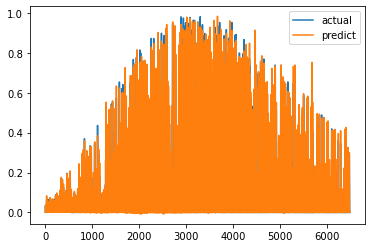

In [8]:
predictlist[['actual','predict']].plot()

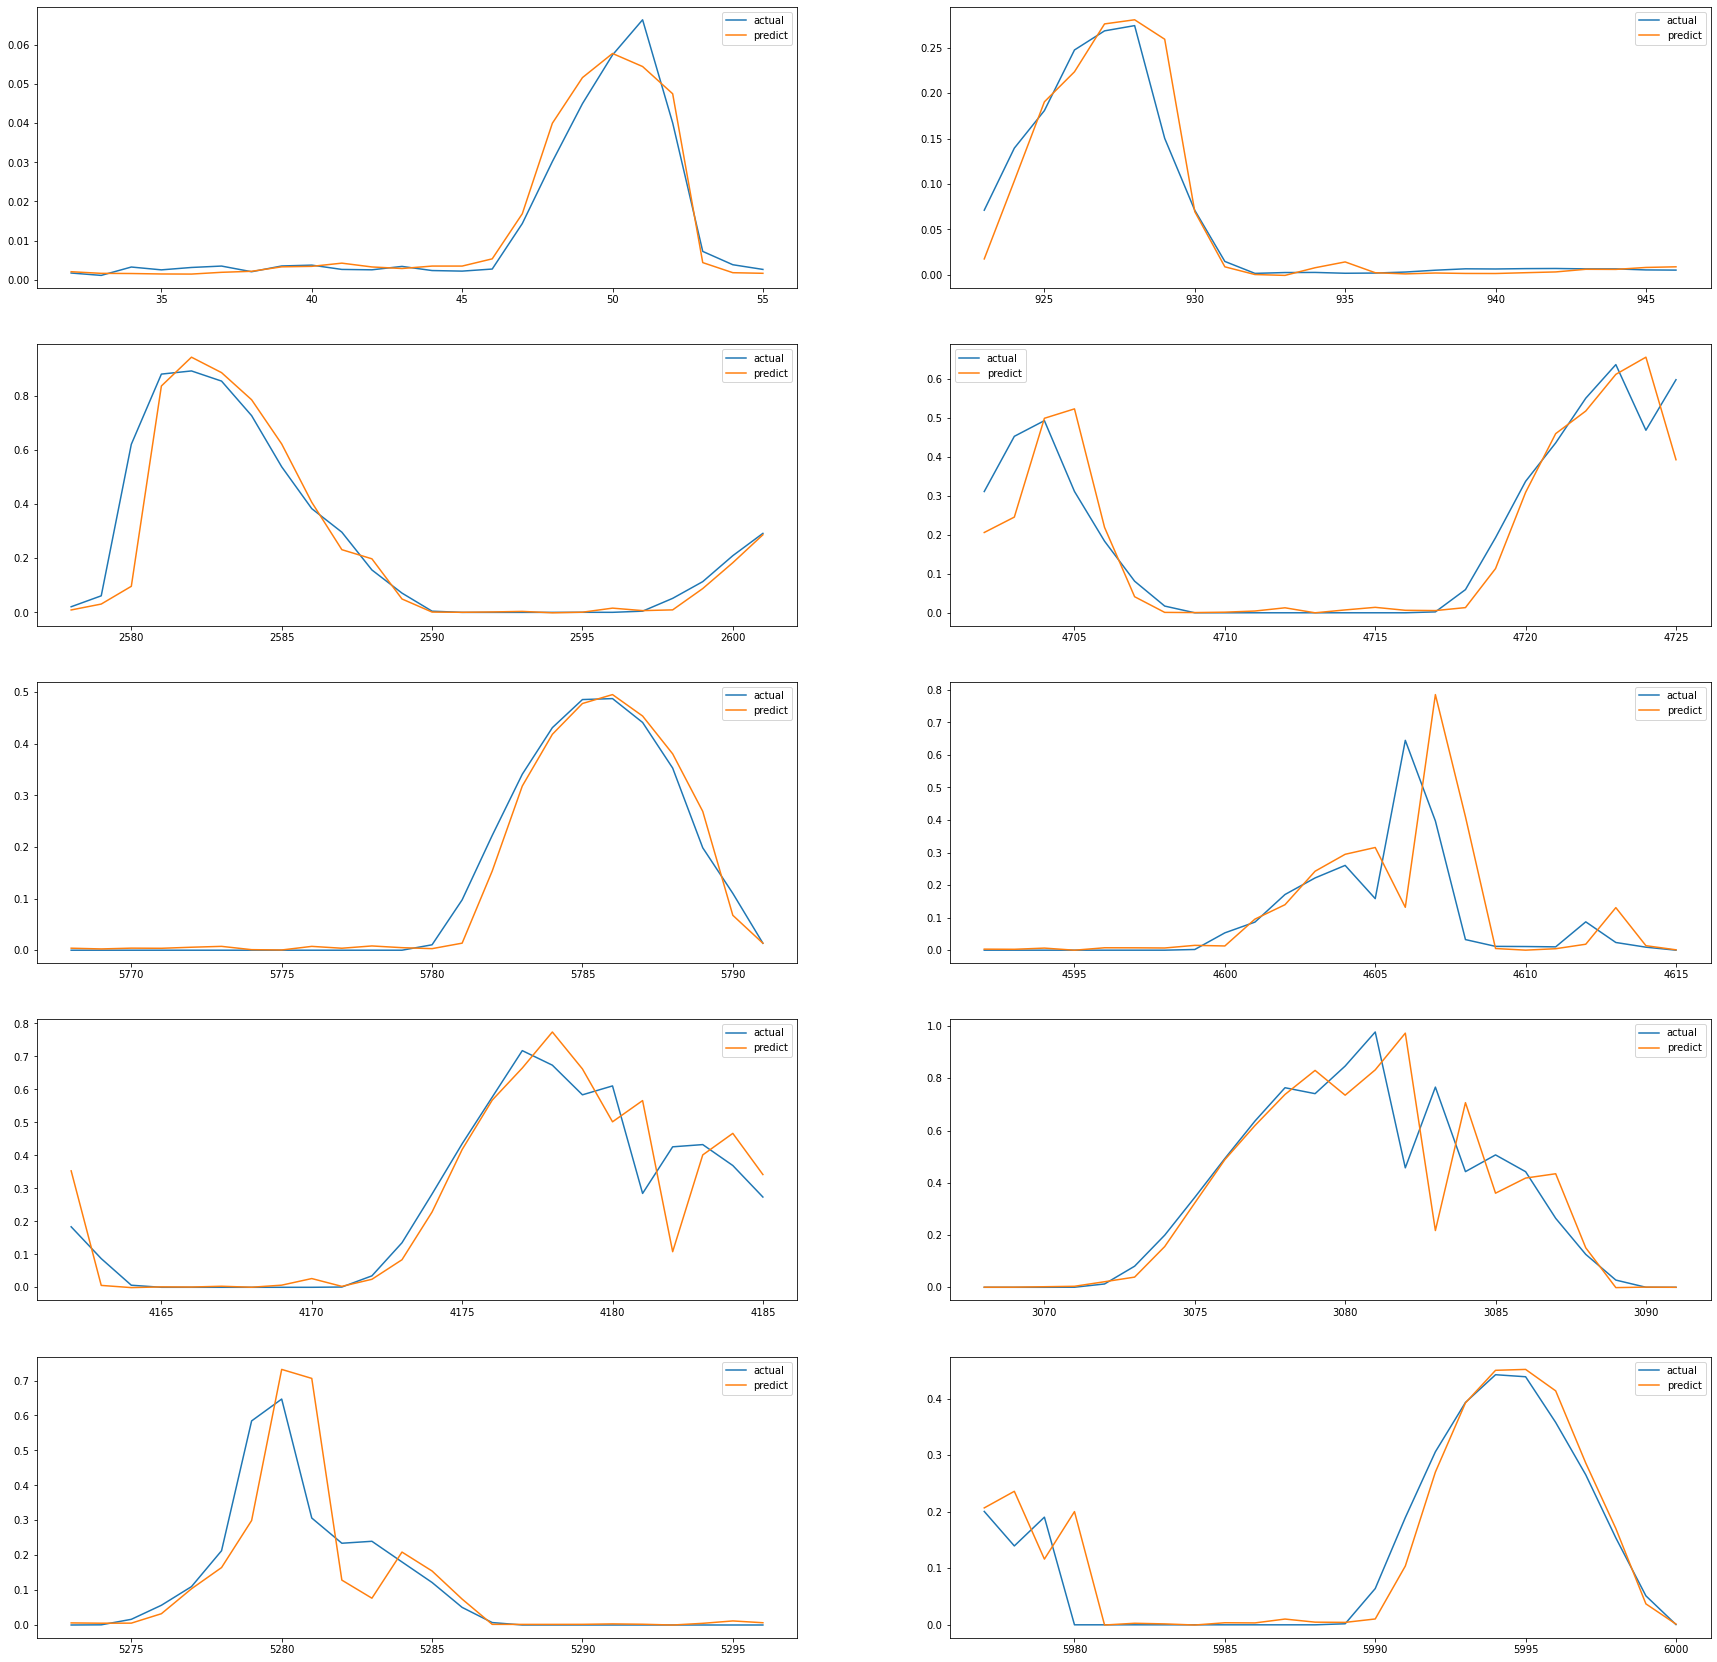

In [9]:
fig,axes=plt.subplots(5,2,figsize=(30,30))
tidx=list(np.random.choice(predictlist.index,10,replace=False))
for i,ax in enumerate(axes.flatten()):
    predictlist[tidx[i]:tidx[i]+24][['actual','predict']].plot(ax=ax)